### Summary

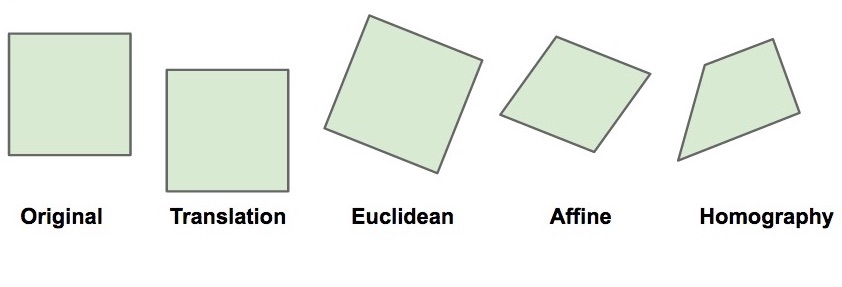

- Align an image to be more clear from homography to a clear basic shape
- Use features of an image to map homography

### Imports and Assets

In [2]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)   

### Main Content

We first need two images: A reference image (original) and an example (homography) to test the alignment

Text(0.5, 1.0, 'Example')

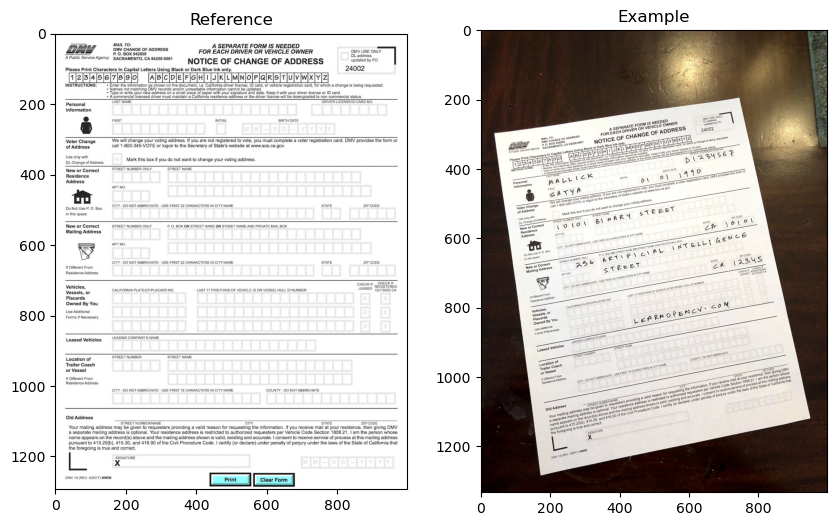

In [3]:
ref = cv2.imread("form.jpg")
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

ex = cv2.imread("scanned-form.jpg")
ex = cv2.cvtColor(ex, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.imshow(ref)
plt.title("Reference")

plt.subplot(122)
plt.imshow(ex)
plt.title("Example")

With these, we find keypoints in order to see how the manifold works from original to a homograph.

Text(0.5, 1.0, 'Example')

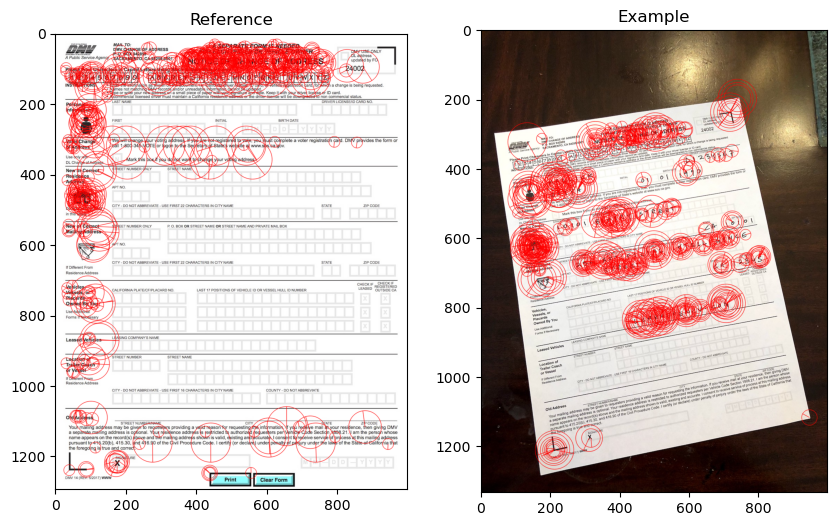

In [4]:
# convert to grayscale
ref_gray = cv2.cvtColor(ref, cv2.COLOR_RGB2GRAY)
ex_gray = cv2.cvtColor(ex, cv2.COLOR_RGB2GRAY)

# create orbs (keypoints)
orb = cv2.ORB_create(500)
ref_keypoints, ref_descs = orb.detectAndCompute(ref_gray, None)
ex_keypoints, ex_descs = orb.detectAndCompute(ex_gray, None)

# display orbs
ref_orbs = cv2.drawKeypoints(ref, ref_keypoints, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ex_orbs = cv2.drawKeypoints(ex, ex_keypoints, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# show displayed orbs in images
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.imshow(ref_orbs)
plt.title("Reference")

plt.subplot(122)
plt.imshow(ex_orbs)
plt.title("Example")

With the keypoints established, we need to find a geometric relation or mapping from the reference to the example.

(-0.5, 1999.5, 1332.5, -0.5)

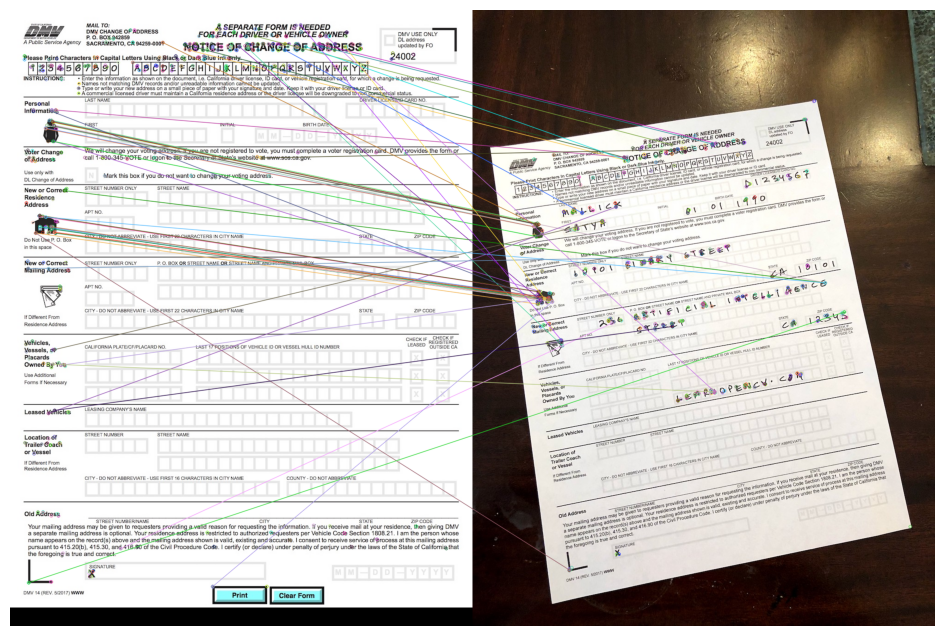

In [18]:
# create matcher
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE)

# connect descriptors
matches = list(matcher.match(ref_descs, ex_descs, None))

# sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# remove bad score matches
num_of_good_matches = int(len(matches) * 0.1)
matches = matches[:num_of_good_matches]

# display matches
matches_img = cv2.drawMatches(ref, ref_keypoints, ex, ex_keypoints, matches, None)

plt.figure(figsize=(24,8))
plt.imshow(matches_img)
plt.axis("off")

With the good matches, we then find its location to create a homography of it.

In [19]:
# get locations of good matches
ref_points = np.zeros((len(matches), 2), dtype=np.float32)
ex_points = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    ref_points[i, :] = ref_keypoints[match.queryIdx].pt
    ex_points[i, :] = ex_keypoints[match.trainIdx].pt

# find homography
homo, mask = cv2.findHomography(ex_points, ref_points, cv2.RANSAC)

With the homograph found, we set it so that the perspective of the ex image is warped according to the homography found

Text(0.5, 1.0, 'Warped Example')

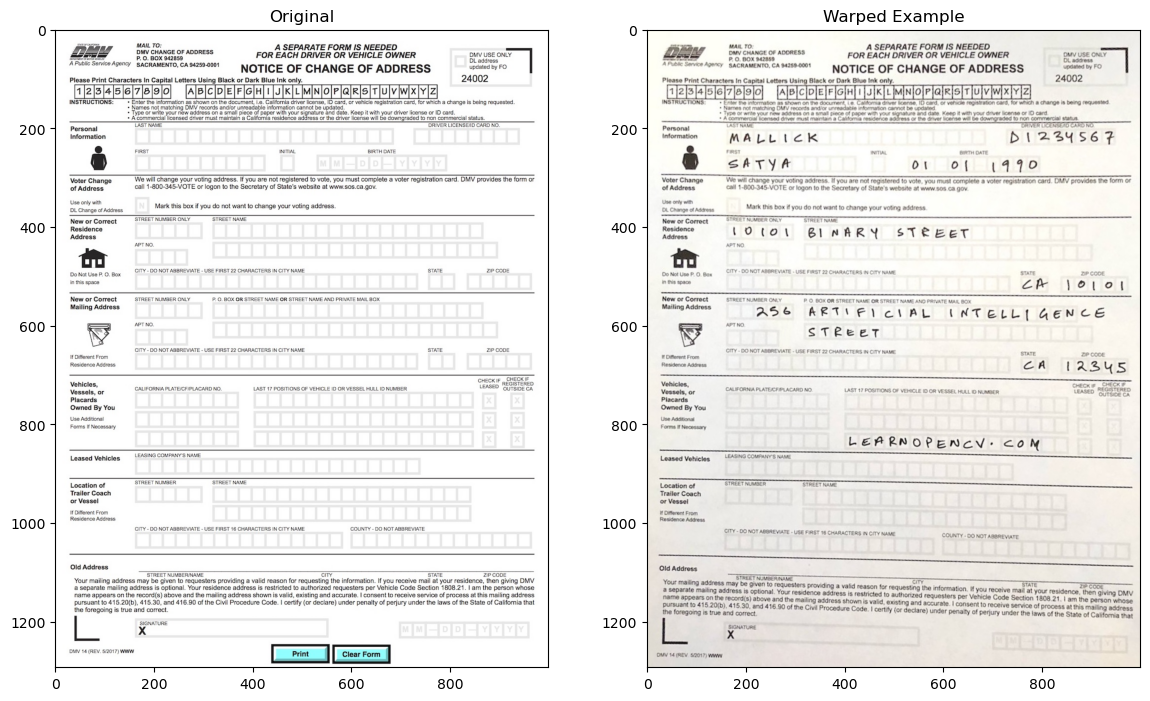

In [20]:
# warp image with homography
height, width, channel = ref.shape
ex_warped = cv2.warpPerspective(ex, homo, (width, height))

# display result
plt.figure(figsize=[14, 10])

plt.subplot(121)
plt.imshow(ref)
plt.title("Original")


plt.subplot(122)
plt.imshow(ex_warped)
plt.title("Warped Example")